# Plot examples

This notebook provides visualizations of the thesis data using custom helper functions from `scripts/viz_utils.py`.

**Sections:**
1. **Demographics** - Sample characteristics (gender, age, education, AI experience)
2. **Experimental Groups** - Balance check between control and uncertainty conditions
3. **Scale Distributions** - Overall distributions of computed scales
4. **Main Analysis** - Scale comparisons by experimental group
5. **Boxplot Comparisons** - Comparing multiple scales side-by-side with boxplots
6. **Stimulus Viewing Time** - Time spent reading experimental materials
7. **Color Customization** - How to adjust the color scheme
8. **Advanced Options** - Label customization and manual effect size calculation

**Note:** All visualizations automatically use human-readable labels from `labels.csv` and support optional grouping by experimental condition.

In [1]:
# Import custom visualization functions
import sys
sys.path.append('..')
from scripts.viz_utils import *

In [2]:
# Load the preprocessed data with computed scale scores
# This file contains only demographics, experimental variables, and computed scales
# (NOT individual survey items)
data = pd.read_csv('../data/data_scales.csv', index_col='ResponseId')

# Display basic information about the dataset
print(f"Dataset shape: {data.shape}")
print(f"Number of participants: {len(data)}")
print(f"\nColumns in dataset:")
print(list(data.columns))

Dataset shape: (255, 20)
Number of participants: 255

Columns in dataset:
['UserLanguage', 'gender', 'age', 'education', 'Q19', 'manip_check1_1', 'manip_check1_2', 'manip_check1_3', 'manip_check1_4', 'manip_check2', 'stimulus_group', 'page_submit', 'ati', 'hcsds_c', 'hcsds_v', 'tia_f', 'tia_pro', 'tia_rc', 'tia_t', 'tia_up']


## 1. Demographics Overview

Basic demographic characteristics of the sample.

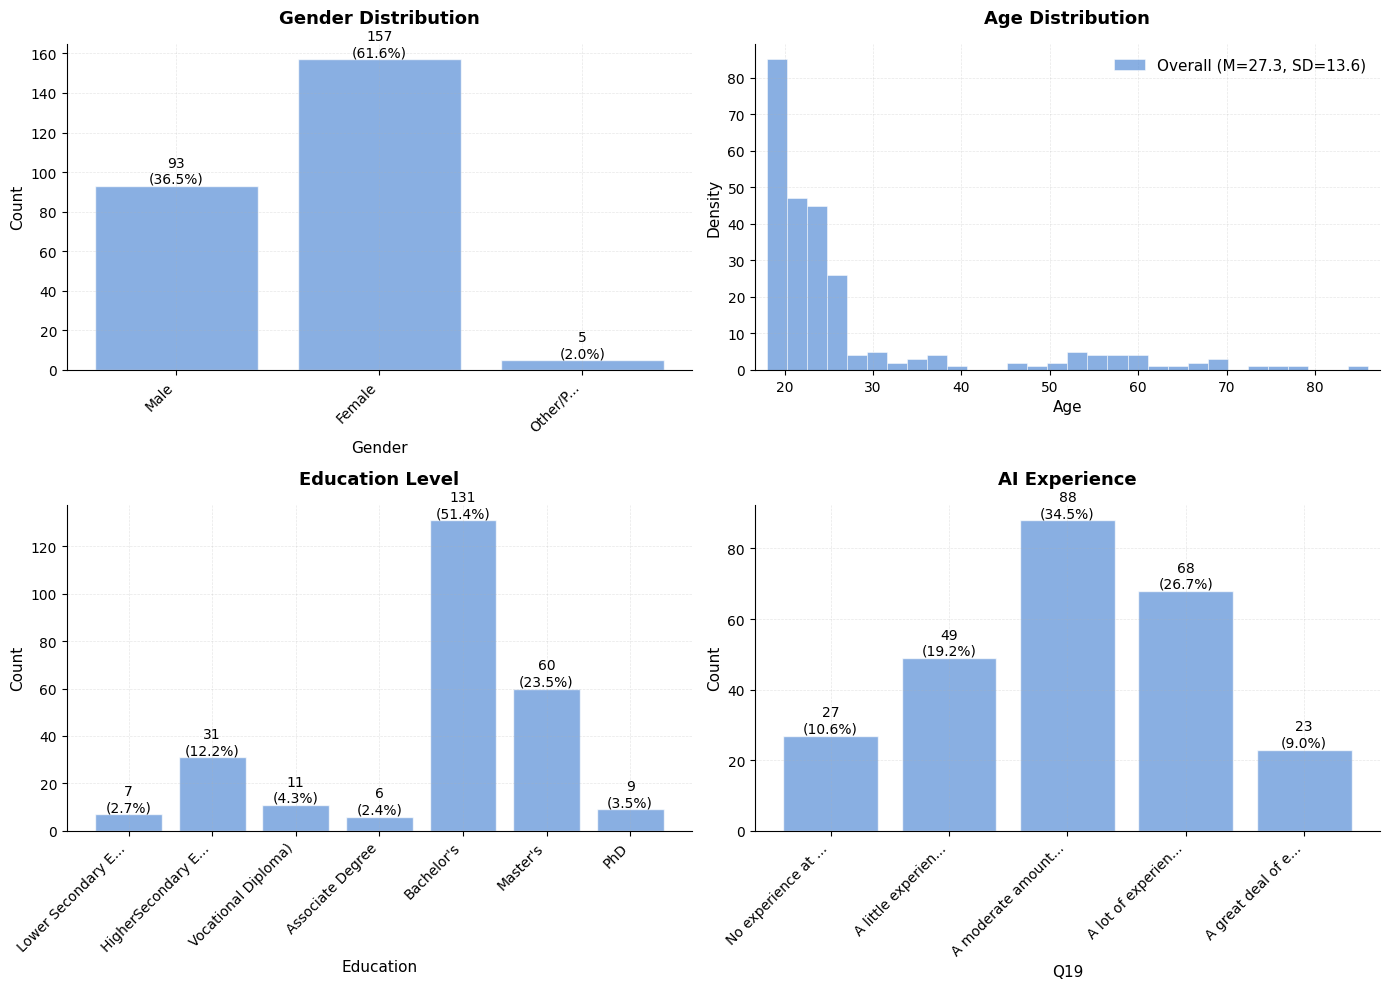

In [3]:
# Create a 2x2 grid for demographic variables
# create_figure_grid() creates a subplot layout with specified number of plots and columns
# Returns: (figure, axes_array) where axes can be indexed to plot into specific subplots
fig, axes = create_figure_grid(4, ncols=2, figsize=(14, 10))

# Plot 1: Gender distribution
# plot_categorical_bar() creates a bar chart for categorical variables
# - Automatically retrieves readable labels from labels.csv (e.g., 1 -> "Male")
# - ax=axes[0] means plot into the first subplot
plot_categorical_bar(data, 'gender', title='Gender Distribution', ax=axes[0], trunc=10)

# Plot 2: Age distribution
# plot_continuous_distribution() creates histogram for continuous variables
# - Shows mean, SD, and sample size in the legend by default
# - KDE overlay is OFF by default (add show_kde=True to enable)
plot_continuous_distribution(data, 'age', title='Age Distribution', ax=axes[1])

# Plot 3: Education level
# Categorical bar chart with readable labels for education levels
plot_categorical_bar(data, 'education', title='Education Level', ax=axes[2])

# Plot 4: AI Experience
# Q19 is a Likert item (1-5) but treated as ordinal categorical here
plot_categorical_bar(data, 'Q19', title='AI Experience', ax=axes[3])

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()

## 2. Experimental Groups Comparison

Check balance between control and uncertainty conditions.

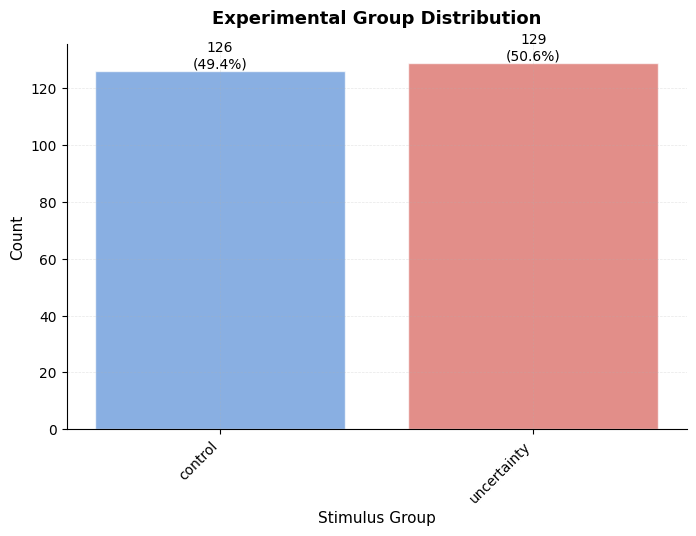

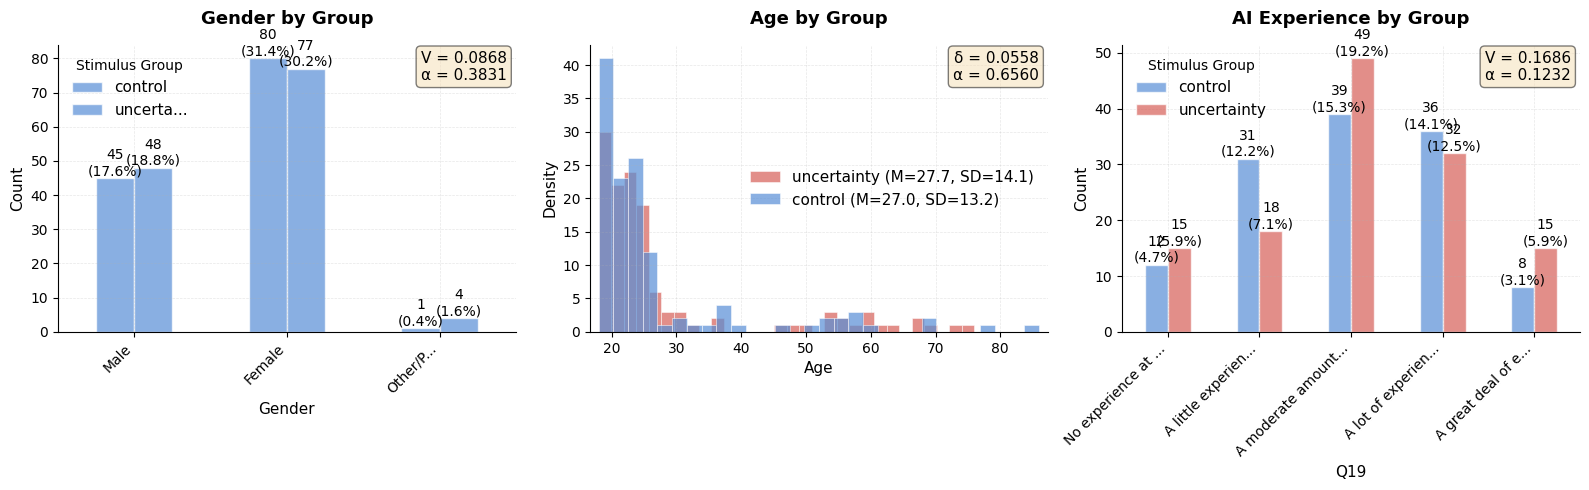

In [4]:
# Check overall distribution of experimental groups
# This shows how many participants were assigned to each condition
fig, ax = plt.subplots(figsize=(8, 5))

# Get value counts for stimulus_group
counts = data['stimulus_group'].value_counts().sort_index()

# Get readable labels
from scripts.viz_utils import get_readable_labels
x_labels = get_readable_labels('stimulus_group', counts.index.tolist(), trunc=20)

# Create manual color mapping using the same colors as the grouped plots
colors = ['#578ED6', '#D65F57']  # Blue for control (0), Pink for uncertainty (1)

# Plot bars with custom colors
bars = ax.bar(range(len(counts)), counts.values, color=colors,
             alpha=0.7, edgecolor='white', linewidth=1)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, counts.values)):
    height = bar.get_height()
    percentage = count / counts.sum() * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{count:.0f}\n({percentage:.1f}%)',
           ha='center', va='bottom', fontsize=10)

# Apply styling
from scripts.viz_utils import apply_consistent_style
apply_consistent_style(ax, title='Experimental Group Distribution', 
                      xlabel='Stimulus Group', ylabel='Count')

plt.show()

# Check demographic balance between experimental groups
# This is important to ensure random assignment worked properly
# group_by='stimulus_group' splits each variable by experimental condition
fig, axes = create_figure_grid(3, ncols=3, figsize=(16, 5))

# Gender distribution by group
# Shows grouped bars: one bar per gender per experimental group
plot_categorical_bar(data, 'gender', group_by='stimulus_group',
                    title='Gender by Group', ax=axes[0], trunc=10)

# Age distribution by group
# Shows overlaid histograms + KDE curves for each experimental group
# Different colors distinguish control vs uncertainty
plot_continuous_distribution(data, 'age', group_by='stimulus_group',
                            title='Age by Group', ax=axes[1], )

# AI experience by group
plot_categorical_bar(data, 'Q19', group_by='stimulus_group',
                    title='AI Experience by Group', ax=axes[2])

plt.tight_layout()
plt.show()

## 3. Scale Distributions

Overview of computed scale scores (ATI, Healthcare Trust, Trust in Automation subscales).

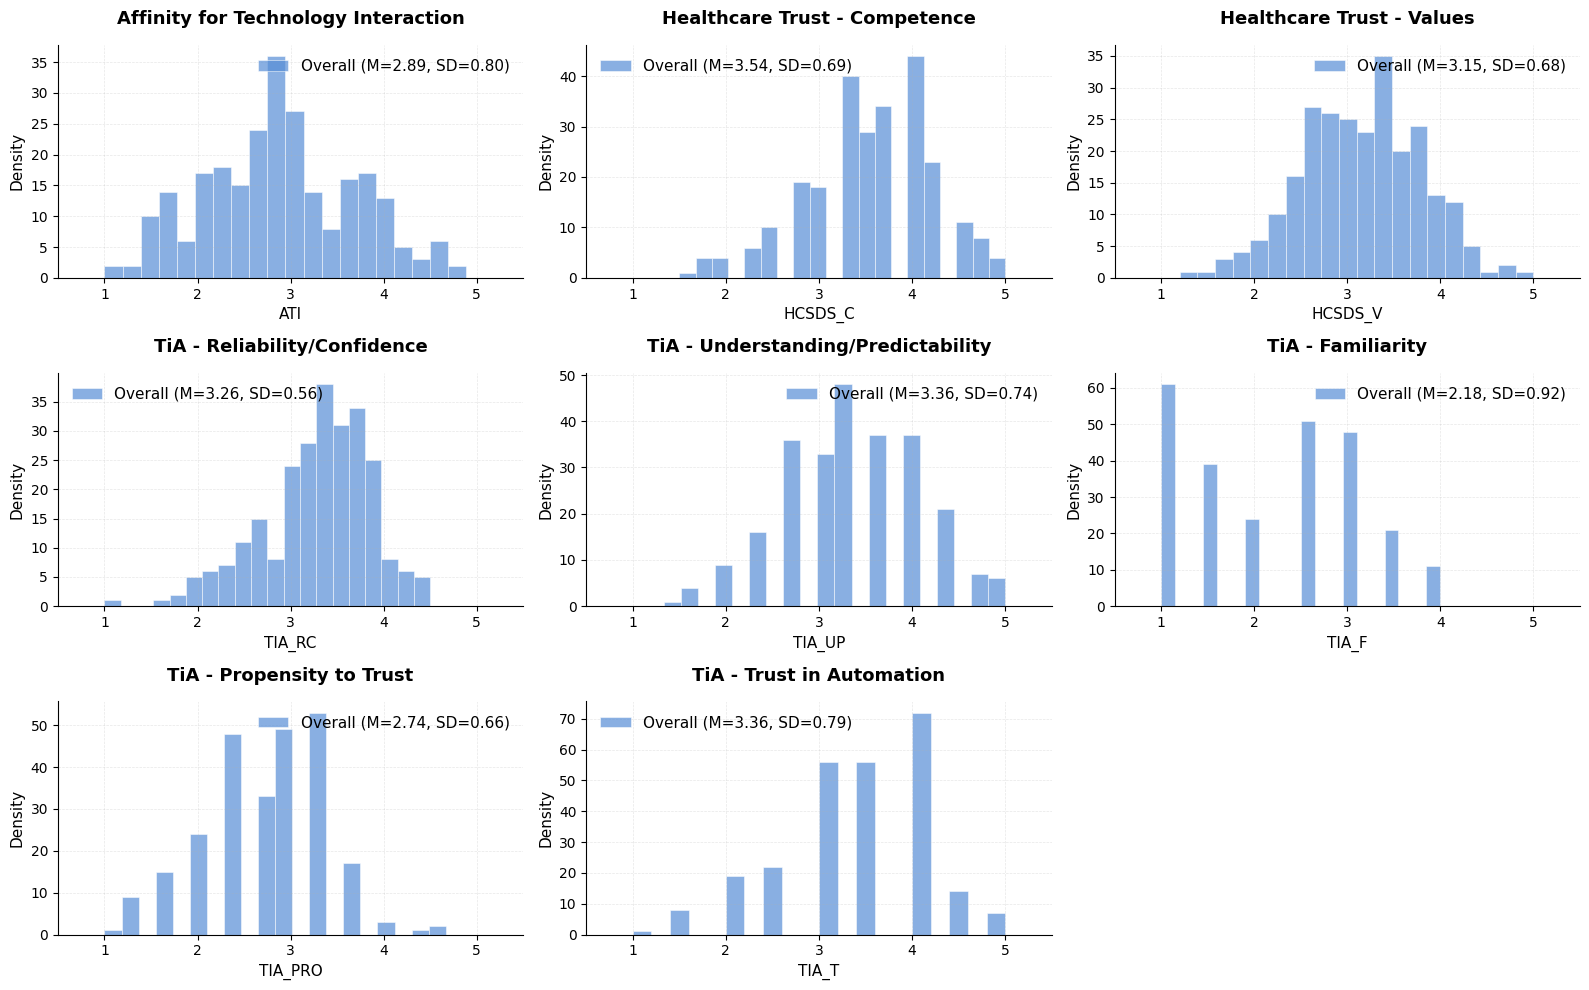

In [5]:
# Plot all computed scale distributions (overall, not split by group)
# These are the averaged scores from multiple survey items

# Define which scale columns to plot
scale_columns = ['ati', 'hcsds_c', 'hcsds_v', 'tia_rc', 'tia_up', 'tia_f', 'tia_pro', 'tia_t']

# Filter to only scales that actually exist in the loaded data
# (in case preprocessing created different columns)
available_scales = [col for col in scale_columns if col in data.columns]

# Create a 3-column grid to display all scales
fig, axes = create_figure_grid(len(available_scales), ncols=3, figsize=(16, 10))

# Define readable titles for each scale
scale_titles = {
    'ati': 'Affinity for Technology Interaction',
    'hcsds_c': 'Healthcare Trust - Competence',
    'hcsds_v': 'Healthcare Trust - Values',
    'tia_rc': 'TiA - Reliability/Confidence',
    'tia_up': 'TiA - Understanding/Predictability',
    'tia_f': 'TiA - Familiarity',
    'tia_pro': 'TiA - Propensity to Trust',
    'tia_t': 'TiA - Trust in Automation'
}

# Loop through each scale and create a distribution plot
# plot_likert_distribution() works for continuous scale scores (averages of Likert items)
# - Histogram shows frequency distribution (NO KDE by default)
# - show_stats=True displays mean, SD, and sample size in legend
# - To add KDE curve overlay, add parameter: show_kde=True
for idx, scale in enumerate(available_scales):
    title = scale_titles.get(scale, scale.upper())
    plot_likert_distribution(data, scale, title=title, ax=axes[idx], show_stats=True)

plt.tight_layout()
plt.show()

## 4. Main Analysis: Scale Distributions by Experimental Group

Compare scale distributions between control and uncertainty conditions.

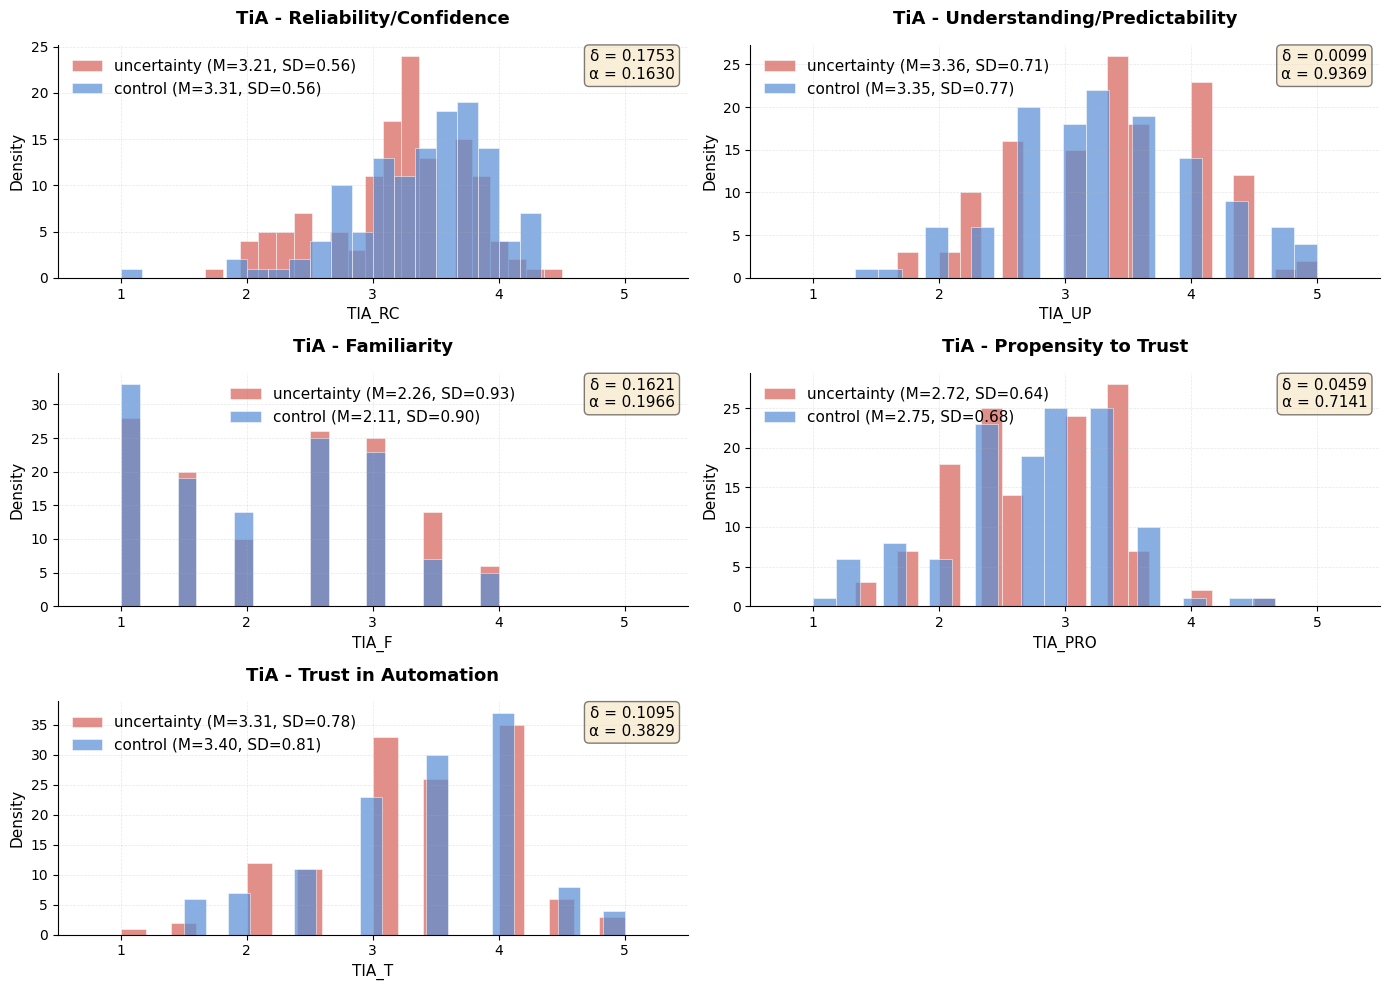

In [6]:
# Plot Trust in Automation subscales with experimental group comparison
# This is the main analysis: comparing outcome variables between conditions

# Trust in Automation (TiA) subscales are the primary dependent variables
tia_scales = ['tia_rc', 'tia_up', 'tia_f', 'tia_pro', 'tia_t']
available_tia = [col for col in tia_scales if col in data.columns]

# Create a 2-column grid for TiA subscales
fig, axes = create_figure_grid(len(available_tia), ncols=2, figsize=(14, 10))

# Plot each TiA subscale with group comparison
# group_by='stimulus_group' creates overlaid distributions:
# - One histogram for control group (default: blue)
# - One histogram for uncertainty group (default: purple)
# - NO KDE curves by default (cleaner visualization)
# - Legend shows mean and SD for each group separately
# - Cohen's d effect size shown in top-right corner (shows magnitude of difference)
#   * |d| < 0.2 = small effect, 0.2-0.5 = small-medium, 0.5-0.8 = medium-large, >0.8 = large
# To disable effect size display, add: show_correlation=False
# To enable KDE overlay, add parameter: show_kde=True
for idx, scale in enumerate(available_tia):
    title = scale_titles.get(scale, scale.upper())
    plot_likert_distribution(data, scale, title=title, 
                           group_by='stimulus_group', ax=axes[idx])

plt.tight_layout()
plt.show()

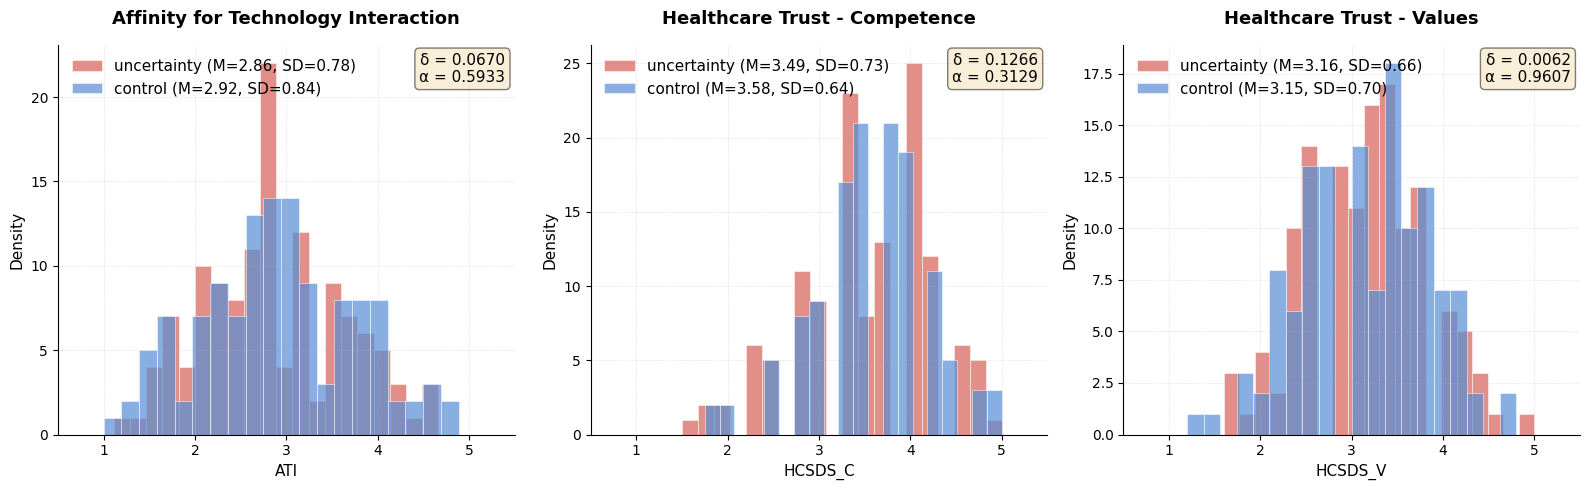

In [7]:
# Plot covariates (control variables) by experimental group
# These should NOT differ significantly between groups (checks randomization)

fig, axes = create_figure_grid(3, ncols=3, figsize=(16, 5))

# ATI: Affinity for Technology Interaction
# Baseline measure of participants' technology affinity
# Used as covariate in statistical analyses
plot_likert_distribution(data, 'ati', title='Affinity for Technology Interaction',
                        group_by='stimulus_group', ax=axes[0])

# Healthcare Trust - Competence subscale
# Baseline trust in healthcare system's competence
if 'hcsds_c' in data.columns:
    plot_likert_distribution(data, 'hcsds_c', title='Healthcare Trust - Competence',
                            group_by='stimulus_group', ax=axes[1])

# Healthcare Trust - Values subscale  
# Baseline trust in healthcare system's values/ethics
if 'hcsds_v' in data.columns:
    plot_likert_distribution(data, 'hcsds_v', title='Healthcare Trust - Values',
                            group_by='stimulus_group', ax=axes[2])

plt.tight_layout()
plt.show()

## 5. Boxplot Comparisons

Boxplots provide a compact way to compare multiple scales side-by-side, showing median, quartiles, and outliers.

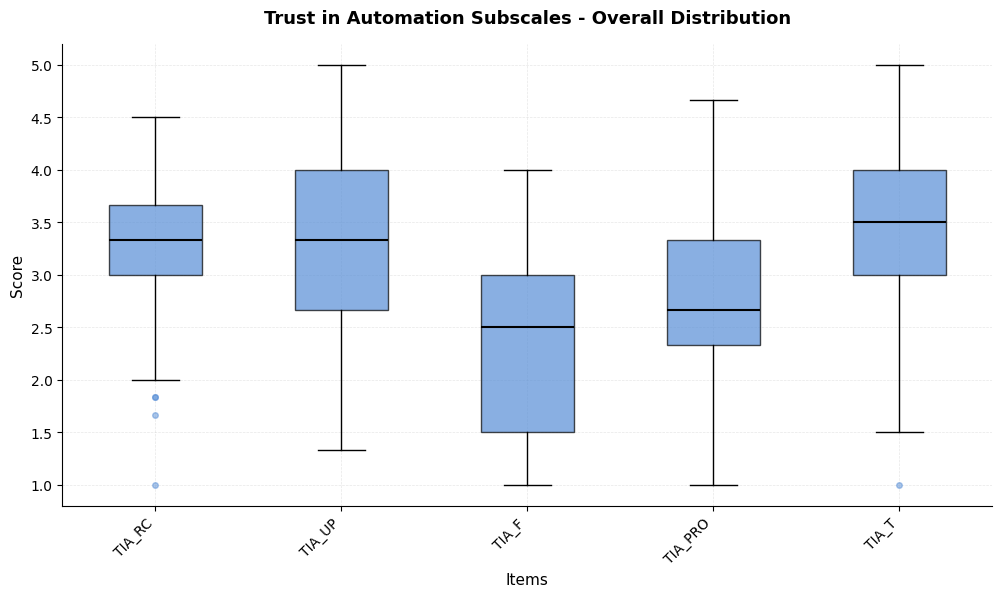

In [8]:
# Example 1: Simple boxplot without grouping
# Shows distribution of all Trust in Automation subscales on one plot
# Each box shows: median (black line), IQR (box), whiskers (1.5×IQR), and outliers (dots)

fig, ax = plt.subplots(figsize=(12, 6))
plot_boxplot(data, ['tia_rc', 'tia_up', 'tia_f', 'tia_pro', 'tia_t'],
             title='Trust in Automation Subscales - Overall Distribution',
             ax=ax)
plt.show()

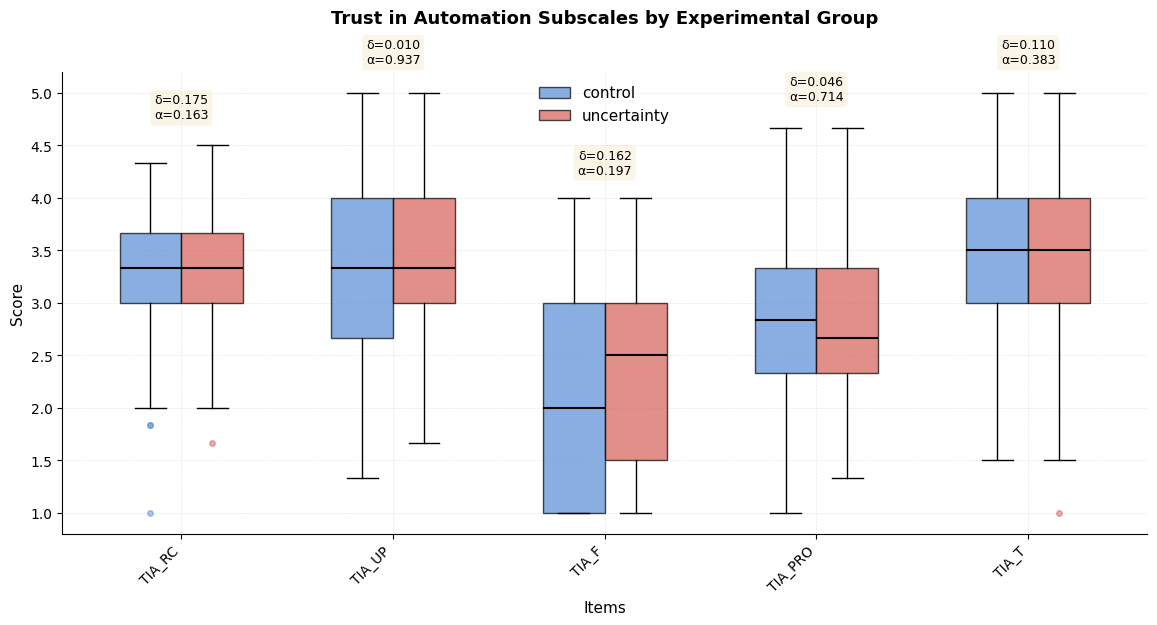

In [9]:
# Example 2: Boxplot with group comparison using default labels
# Compares control vs uncertainty group for each subscale
# - Items are grouped together with control/uncertainty boxes side-by-side
# - Cohen's d and p-value displayed above each item comparison
# - All items share the same y-axis scale (ideal for Likert scales)

fig, ax = plt.subplots(figsize=(14, 6))
plot_boxplot(data, ['tia_rc', 'tia_up', 'tia_f', 'tia_pro', 'tia_t'],
             group_by='stimulus_group',
             title='Trust in Automation Subscales by Experimental Group',
             ax=ax)
plt.show()

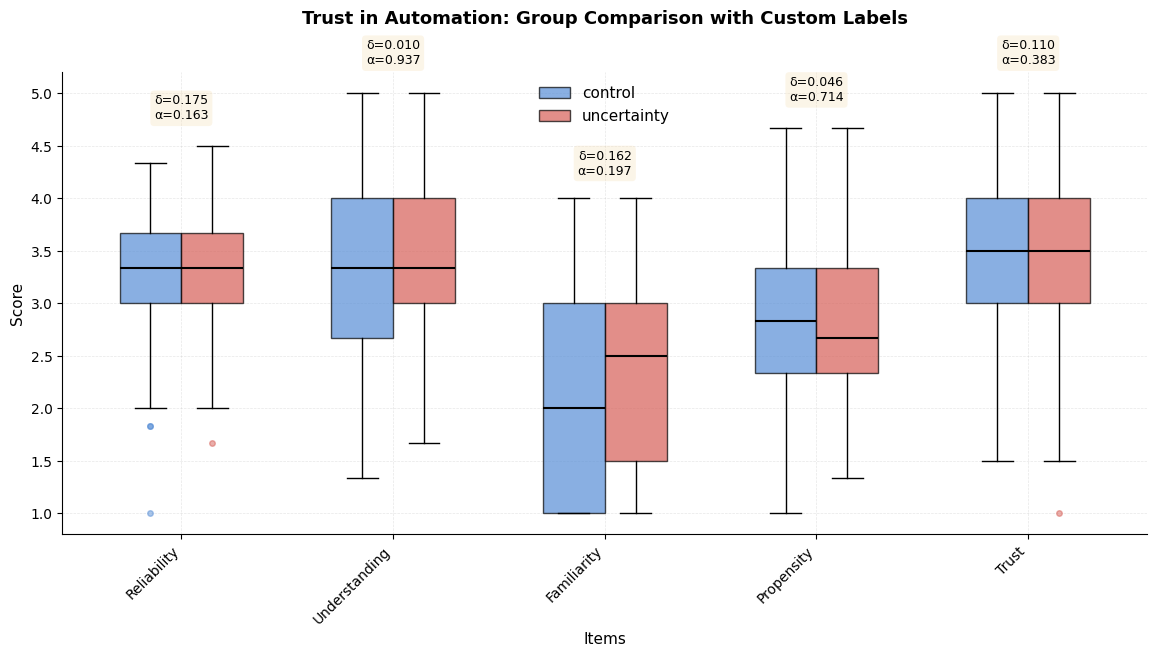

Note: short_labels length must match the number of columns provided


In [10]:
# Example 3: Boxplot with custom short labels
# Use short_labels parameter to provide readable, concise labels for x-axis
# This is useful when default column names are too technical

fig, ax = plt.subplots(figsize=(14, 6))
plot_boxplot(data, ['tia_rc', 'tia_up', 'tia_f', 'tia_pro', 'tia_t'],
             group_by='stimulus_group',
             short_labels=['Reliability', 'Understanding', 'Familiarity', 'Propensity', 'Trust'],
             title='Trust in Automation: Group Comparison with Custom Labels',
             ax=ax)
plt.show()

print("Note: short_labels length must match the number of columns provided")

In [11]:
# Example 4: Using full labels from labels.csv (optional)
# Set use_full_labels=True to load full question text from labels.csv
# Labels are automatically truncated to 30 characters for readability
# Note: This works best when your labels.csv has descriptive question text

# Uncomment to try with full labels:
# fig, ax = plt.subplots(figsize=(14, 6))
# plot_boxplot(data, ['tia_rc', 'tia_up'],
#              group_by='stimulus_group',
#              use_full_labels=True,
#              title='Example with Full Labels from labels.csv',
#              ax=ax)
# plt.show()

print("Boxplot customization options:")
print("- Default: Uses column names in uppercase (e.g., 'TIA_RC')")
print("- short_labels=['A', 'B', ...]: Custom short labels")
print("- use_full_labels=True: Loads full text from labels.csv (auto-truncated to 30 chars)")
print("- show_stats=True (default): Shows Cohen's d and p-value when comparing groups")
print("- show_stats=False: Hides statistical annotations")

Boxplot customization options:
- Default: Uses column names in uppercase (e.g., 'TIA_RC')
- short_labels=['A', 'B', ...]: Custom short labels
- use_full_labels=True: Loads full text from labels.csv (auto-truncated to 30 chars)
- show_stats=True (default): Shows Cohen's d and p-value when comparing groups
- show_stats=False: Hides statistical annotations


## 6. Stimulus Viewing Time

Analyze time spent viewing the experimental stimulus.

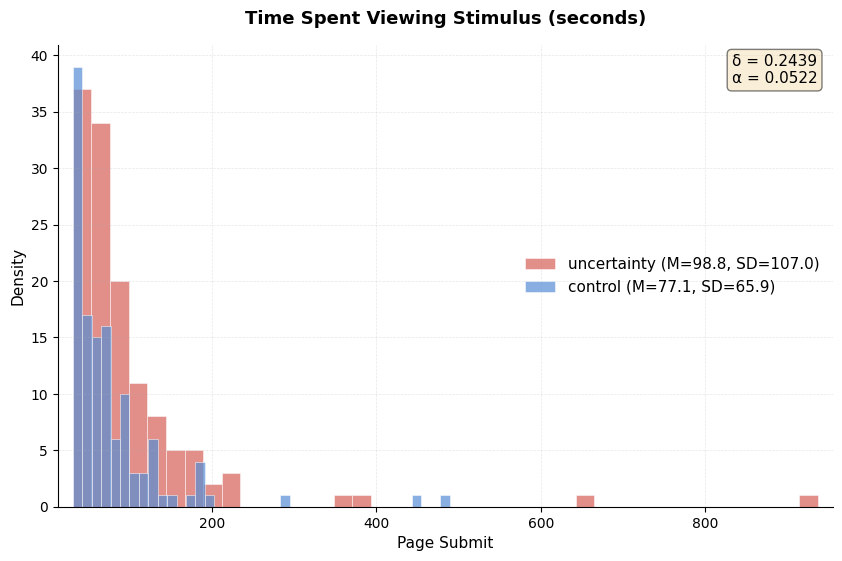


Stimulus viewing time by group:
                count       mean         std     min       25%      50%  \
stimulus_group                                                            
0               126.0  77.122571   65.893363  30.945  39.93175  58.5765   
1               129.0  98.797907  107.040916  30.781  49.85400  69.2060   

                      75%      max  
stimulus_group                      
0                89.88675  489.020  
1               111.44900  937.005  


In [12]:
# Analyze time spent viewing the experimental stimulus (leaflet)
# Longer viewing times may indicate more engagement with uncertainty information

fig, ax = plt.subplots(figsize=(10, 6))

# Plot page_submit time distribution by experimental group
# page_submit = time in seconds spent on the stimulus page
# group_by='stimulus_group' shows if uncertainty condition took longer to read
# bins=40 creates more granular histogram (default is 30)
# NO KDE by default - add show_kde=True if you want the smooth curve overlay
plot_continuous_distribution(data, 'page_submit', 
                            title='Time Spent Viewing Stimulus (seconds)',
                            group_by='stimulus_group', ax=ax, bins=40)

plt.show()

# Print detailed summary statistics
# groupby() splits data by experimental group, then describe() shows stats
print("\nStimulus viewing time by group:")
print(data.groupby('stimulus_group')['page_submit'].describe())

## 7. Customizing Colors (Optional)

You can customize the color scheme to match your preferences.

In [13]:
# Customize the color scheme for your plots
# Colors are defined as hexadecimal codes (e.g., '#3498DB' is a shade of blue)

# Option 1: Uncomment to use custom colors
# set_custom_colors({
#     'control': '#3498DB',        # Blue for control group
#     'uncertainty': '#E74C3C',    # Red for uncertainty group
#     'primary': '#2C3E50',        # Dark gray for overall plots (no grouping)
#     'accent': '#F39C12'          # Orange for accent elements
# })

# After uncommenting and running set_custom_colors(), 
# re-run any plot cells above to see the new colors applied

# Option 2: Example plot with custom colors applied
# Uncomment to see the effect:
# fig, ax = plt.subplots(figsize=(10, 6))
# plot_likert_distribution(data, 'tia_t', group_by='stimulus_group', 
#                         title='Trust in Automation by Group', ax=ax)
# plt.show()

# Note: You can find color codes at https://htmlcolorcodes.com/
# or use named colors like 'blue', 'red', 'green', etc.

## 8. Advanced Options for Likert Plots

Additional parameters for customizing Likert scale visualizations.

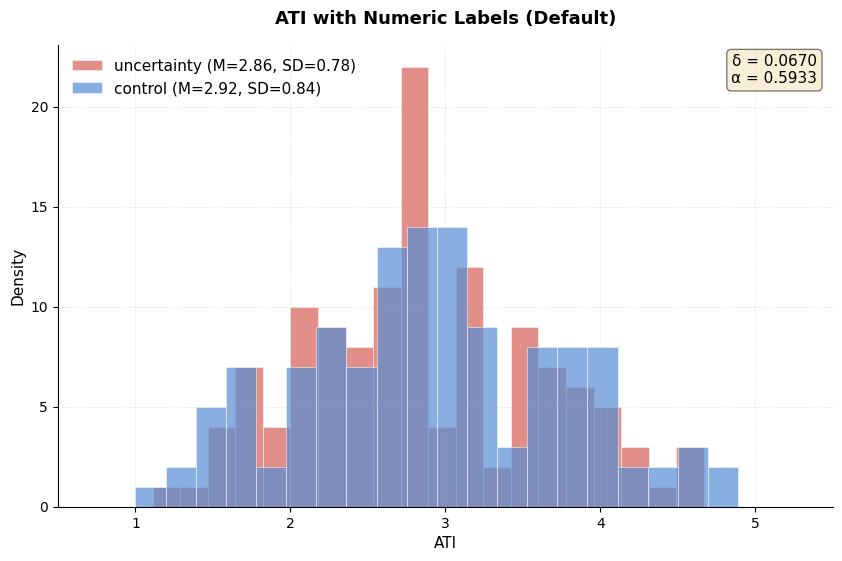

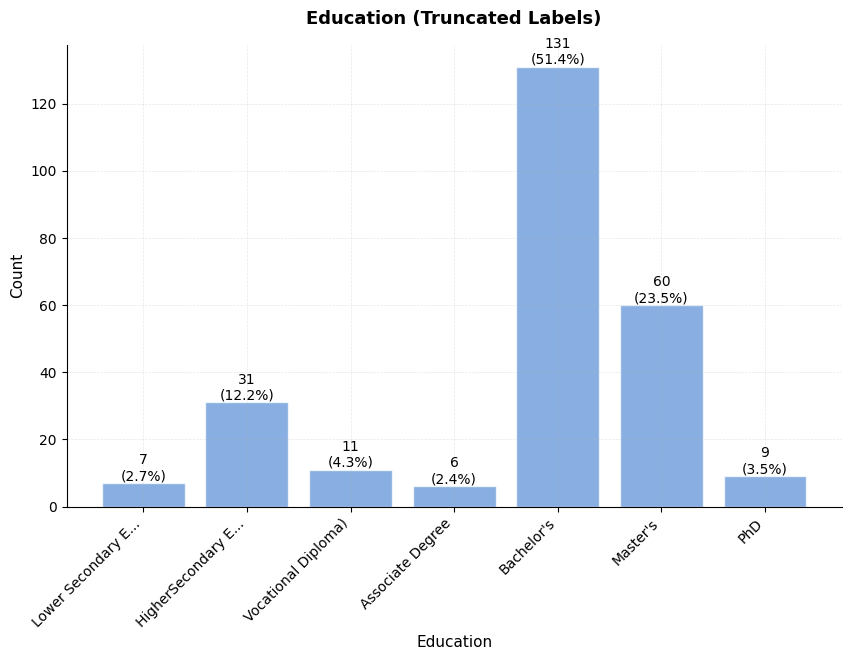

Label truncation examples:
- trunc=-1 (default): No truncation - shows full label text
- trunc=15: Truncates to 15 characters (e.g., 'Strongly disagr...')
- trunc=20: Truncates to 20 characters
- Works for all plot types: categorical bars and Likert plots with labels


In [14]:
# Example 1: Default behavior - numeric labels (1, 2, 3, 4, 5)
# All Likert plots use a consistent 1-5 range by default
fig, ax = plt.subplots(figsize=(10, 6))
plot_likert_distribution(data, 'ati', title='ATI with Numeric Labels (Default)',
                        group_by='stimulus_group', ax=ax)
plt.show()

# Example 2: With text labels from labels.csv
# show_labels=True displays "Strongly disagree", "Somewhat disagree", etc.
# trunc parameter controls label length:
#   - trunc=-1 (default): No truncation, full label text
#   - trunc=15: Truncate to 15 characters (e.g., "Strongly disagr...")
#   - trunc=20: Truncate to 20 characters
# Note: This works best for individual items (ATI_1, ATI_2) rather than computed scales
# Uncomment to see individual item with labels:
# fig, ax = plt.subplots(figsize=(10, 6))
# plot_likert_distribution(data, 'ATI_1', title='Individual ATI Item with Text Labels',
#                         show_labels=True, likert_range=5, trunc=15, ax=ax)
# plt.show()

# Example 3: Categorical plot with truncated labels
# Use trunc parameter to shorten long category names like education levels
fig, ax = plt.subplots(figsize=(10, 6))
plot_categorical_bar(data, 'education', title='Education (Truncated Labels)',
                    trunc=20, ax=ax)  # Truncate education labels to 20 chars
plt.show()

# Example 4: Custom Likert range (e.g., for 7-point scale)
# If you have a 7-point Likert scale, set likert_range=7
# This ensures x-axis ranges from 1 to 7
# fig, ax = plt.subplots(figsize=(10, 6))
# plot_likert_distribution(data, 'custom_7pt_variable', title='7-Point Likert Scale',
#                         likert_range=7, ax=ax)
# plt.show()

print("Label truncation examples:")
print("- trunc=-1 (default): No truncation - shows full label text")
print("- trunc=15: Truncates to 15 characters (e.g., 'Strongly disagr...')")
print("- trunc=20: Truncates to 20 characters")
print("- Works for all plot types: categorical bars and Likert plots with labels")

## 9. Computing Effect Sizes Manually

You can also calculate Cohen's d effect size directly using the utility function.

In [15]:
# Import the cohens_d function from utils
from scripts.stats import cohens_d

# Example: Calculate effect size for ATI between experimental groups
# Split data by experimental group
control_group = data[data['stimulus_group'] == 0]['ati']
uncertainty_group = data[data['stimulus_group'] == 1]['ati']

# Calculate Cohen's d
effect_size = cohens_d(control_group, uncertainty_group)

print(f"Effect size for ATI between groups:")
print(f"Cohen's d = {effect_size:.3f}")
print()

# Interpretation
if abs(effect_size) < 0.2:
    interpretation = "small effect (trivial difference)"
elif abs(effect_size) < 0.5:
    interpretation = "small to medium effect"
elif abs(effect_size) < 0.8:
    interpretation = "medium to large effect"
else:
    interpretation = "large effect (substantial difference)"

print(f"Interpretation: {interpretation}")
print()

# Calculate effect sizes for all TiA subscales
print("Effect sizes for all Trust in Automation subscales:")
print("-" * 60)

tia_scales = ['tia_rc', 'tia_up', 'tia_f', 'tia_pro', 'tia_t']
for scale in tia_scales:
    if scale in data.columns:
        control = data[data['stimulus_group'] == 0][scale]
        uncertainty = data[data['stimulus_group'] == 1][scale]
        d = cohens_d(control, uncertainty)
        print(f"{scale:10s}: Cohen's d = {d:6.3f}")

print()
print("Note: The cohens_d() function is now available in scripts/utils.py")
print("You can use it for any pairwise group comparisons!")

Effect size for ATI between groups:
Cohen's d = 0.067

Interpretation: small effect (trivial difference)

Effect sizes for all Trust in Automation subscales:
------------------------------------------------------------
tia_rc    : Cohen's d =  0.175
tia_up    : Cohen's d =  0.010
tia_f     : Cohen's d =  0.162
tia_pro   : Cohen's d =  0.046
tia_t     : Cohen's d =  0.110

Note: The cohens_d() function is now available in scripts/utils.py
You can use it for any pairwise group comparisons!
